In [23]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
from typing import NamedTuple
from flax.training import train_state
import optax
import flax.linen as nn
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')

from mcjax.proba.density import LogDensity
from mcjax.process.ou import OU
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.banana2d import Banana2D

from mcjax.process.dds import MLPModel, dds_loss,train_step


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Parameters initialization
K = 1000
sigma = 1.0
learning_rate = 1e-4
batch_size = 128
num_steps = 200_000
data_dim = 1

timesteps = jnp.arange(K, dtype=jnp.float32)
beta_start, beta_end = 0.1, 20.0
beta = beta_start + (beta_end - beta_start) * (timesteps / (K - 1))
alpha = 1.0 - jnp.exp(-2.0 * beta / K)

(10000, 2)


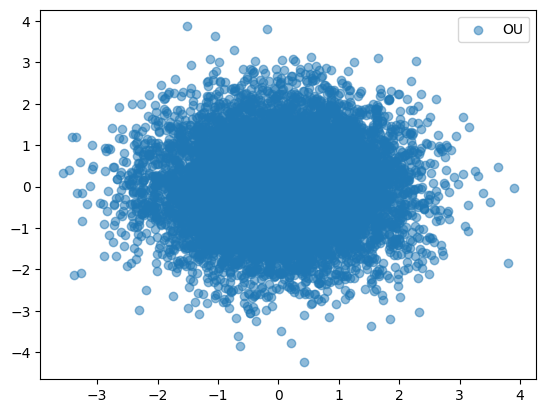

In [28]:
# Test the forward process
# init_dist = IsotropicGauss(mu=jnp.ones(data_dim), log_var=3.0)
init_dist = Banana2D()
key = jr.PRNGKey(0)
key, key_ = jr.split(key)
ou = OU(alpha=alpha, sigma=sigma, init_dist=init_dist)
xK = ou.sample(key_, 10000, K)
print(xK.shape)
target_dist = IsotropicGauss(mu=jnp.zeros(data_dim), log_var=jnp.log(sigma**2))
# x_target = target_dist.sample(key, 10000)
# plt.hist(x_target, bins=50, density=True, label='target', alpha= 0.5)
# plt.hist(xK, bins=50, density=True, label='OU', alpha= 0.5)
plt.scatter(xK[:,0], xK[:,1], label='OU', alpha= 0.5)
plt.legend()

In [13]:
# Model Initialization
init_dist = IsotropicGauss(mu=jnp.zeros(data_dim), log_var=0.0)

# target distribution is a mixture of 2 gaussians
target_dist = IsotropicGauss(mu=jnp.ones(data_dim), log_var=1.0)
ou = OU(alpha=alpha, sigma=sigma, init_dist=init_dist)
model = MLPModel(dim=1, T=K)

# network initialization
key = jr.PRNGKey(0)
key, key_ = jr.split(key)
dummy_x = jnp.zeros((1, data_dim))
dummy_t = jnp.zeros((1,), dtype=jnp.int32)
params = model.init(key_, dummy_x, dummy_t)

# optimizer initialization  
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)


Available devices: [CpuDevice(id=0)]


In [14]:
# score function
def score_fn(params, k, y):
    batch_t = jnp.full((y.shape[0],), k, dtype=jnp.int32)
    return model.apply(params, y, batch_t)

In [ ]:
def scan_step(carry, step):
    state, key = carry
    key, key_ = jr.split(key)
    state, loss = train_step(state, ou, init_dist, target_dist, score_fn, optimizer, batch_size, key_)
    return (state, key), loss

@jax.jit
def run_training(state, key):
    (final_state, final_key), losses = jax.lax.scan(
        scan_step,
        (state, key),
        jnp.arange(num_steps),
        length=num_steps
    )
    return final_state, final_key, losses



In [16]:
# Training loop
key, key_ = jr.split(key)
state, key, losses = run_training(state, key_)

# Save the model
jax.save(state.params, 'model_params.pkl')

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('loss_curve.png')


Entering step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=2/0)>...
Step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=4/0)>: y_next = Traced<ShapedArray(float32[128,1])>with<DynamicJaxprTrace(level=4/0)>, r_next = Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=4/0)>
Step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=6/0)>: y_next = Traced<ShapedArray(float32[128,1])>with<DynamicJaxprTrace(level=6/0)>, r_next = Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=6/0)>
Step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=8/0)>: y_next = Traced<ShapedArray(float32[128,1])>with<DynamicJaxprTrace(level=8/0)>, r_next = Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=8/0)>
Step Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=10/0)>: y_next = Traced<ShapedArray(float32[128,1])>with<DynamicJaxprTrace(level=10/0)>, r_next = Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=10/0)>
Step Traced<S

KeyboardInterrupt: 